In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [0]:
N = 1024
nb_epoch = 501
batch_size = 32
nb_features = 64
Q = 1
nb_output = 2  # total number of output
D1 = 1  # first output
D2 = 1  # second output

# Evaluate on synthetic data

In [0]:
def gen_data(N):
    X = np.random.randn(N, Q)
    # y1 = 2x + 8
    w1 = 2.
    b1 = 8.
    sigma1 = 1e1  # ground truth
    Y1 = X.dot(w1) + b1 + sigma1 * np.random.randn(N, D1)
    # y2 = 3x+3
    w2 = 3
    b2 = 3.
    sigma2 = 1e0  # ground truth
    Y2 = X.dot(w2) + b2 + sigma2 * np.random.randn(N, D2)
    return X, Y1, Y2

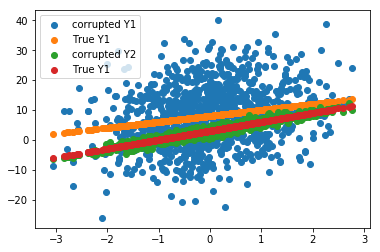

In [0]:
import pylab
%matplotlib inline

X, Y1, Y2 = gen_data(N)
#pylab.figure(figsize=(3, 1.5))
pylab.scatter(X[:, 0], Y1[:, 0], label='corrupted Y1')
pylab.scatter(X[:, 0], 2*X[:, 0]+8, label='True Y1')
pylab.scatter(X[:, 0], Y2[:, 0], label='corrupted Y2')
pylab.scatter(X[:, 0], 3*X[:, 0]+3, label='True Y1')
pylab.legend()
pylab.show()

# Example Model

In [0]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output1_size, output2_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output1_size)
        self.fc3 = nn.Linear(hidden_size, output2_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out1 = self.fc2(out)
        out2 = self.fc3(out)
        return out1, out2

In [0]:
model = Net(Q, nb_features, D1, D2)

## Define task dependent log_variance

In [0]:
log_var_a = torch.zeros((1,), requires_grad=True)
log_var_b = torch.zeros((1,), requires_grad=True)

# log_var_a = torch.tensor([3.0,], requires_grad=True)
# log_var_b = torch.tensor([3.0,], requires_grad=True)

In [0]:
# Initialized standard deviations (ground truth is 10 and 1):
std_1 = torch.exp(log_var_a)**0.5
std_2 = torch.exp(log_var_b)**0.5
print([std_1.item(), std_2.item()])

[1.0, 1.0]


In [0]:
# get all parameters (model parameters + task dependent log variances) for MTUW network
params = ([p for p in model.parameters()] + [log_var_a] + [log_var_b])
optimizer = optim.Adam(params)

## Define loss criterion with multi-task-uncertainty-weightage

In [0]:
def criterion(y_pred, y_true, log_vars):
  loss = 0
  for i in range(len(y_pred)):
    precision = torch.exp(-log_vars[i])
    diff = (y_pred[i]-y_true[i])**2.
    loss += torch.mean(precision * diff + log_vars[i])
  return loss

## Train the network with MTUW

In [0]:
# convert data into torch from numpy array
X = X.astype('float32')
Y1 = Y1.astype('float32')
Y2 = Y2.astype('float32')

In [0]:
def shuffle_data(X,Y1,Y2):
    s = np.arange(X.shape[0])
    np.random.shuffle(s)
    return X[s], Y1[s], Y2[s]

In [0]:
## Train Network
loss_history = np.zeros(nb_epoch)
std_1_history = np.zeros(nb_epoch)
std_2_history = np.zeros(nb_epoch)

for i in range(nb_epoch):

    epoch_loss = 0
    
    X, Y1, Y2 = shuffle_data(X, Y1, Y2)
    
    for j in range(N//batch_size):
        
        optimizer.zero_grad()
        
        inp = torch.from_numpy(X[(j*batch_size):((j+1)*batch_size)])
        target1 = torch.from_numpy(Y1[(j*batch_size):((j+1)*batch_size)])
        target2 = torch.from_numpy(Y2[(j*batch_size):((j+1)*batch_size)])
        
        out = model(inp)
        
        loss = criterion(out, [target1, target2], [log_var_a, log_var_b])
        
        epoch_loss += loss.item()
        
        loss.backward()
        
        optimizer.step()
   
    loss_history[i] = epoch_loss * batch_size / N    
    
    std_1 = torch.exp(log_var_a)**0.5
    std_2 = torch.exp(log_var_b)**0.5

    std_1_history[i] = std_1.item()
    std_2_history[i] = std_2.item()
    
    if i%50 == 0:
        # Found standard deviations (ground truth is 10 and 1):
        print('Epoch: {:04d}, Loss: {:.04f}, Task 1 std: {:.04f}, Task 2 std: {:.04f}'.format(i, loss_history[i], std_1_history[i], std_2_history[i]))

Epoch: 0000, Loss: 174.6699, Task 1 std: 1.0159, Task 2 std: 1.0156
Epoch: 0050, Loss: 34.3319, Task 1 std: 1.7114, Task 2 std: 1.0337
Epoch: 0100, Loss: 17.2113, Task 1 std: 2.5575, Task 2 std: 0.9828
Epoch: 0150, Loss: 10.6953, Task 1 std: 3.6124, Task 2 std: 0.9579
Epoch: 0200, Loss: 7.9625, Task 1 std: 4.9327, Task 2 std: 0.9548
Epoch: 0250, Loss: 6.8730, Task 1 std: 6.4974, Task 2 std: 0.9550
Epoch: 0300, Loss: 6.5142, Task 1 std: 8.0977, Task 2 std: 0.9537
Epoch: 0350, Loss: 6.4505, Task 1 std: 9.2529, Task 2 std: 0.9536
Epoch: 0400, Loss: 6.4467, Task 1 std: 9.6377, Task 2 std: 0.9541
Epoch: 0450, Loss: 6.4480, Task 1 std: 9.6688, Task 2 std: 0.9527
Epoch: 0500, Loss: 6.4407, Task 1 std: 9.6567, Task 2 std: 0.9529


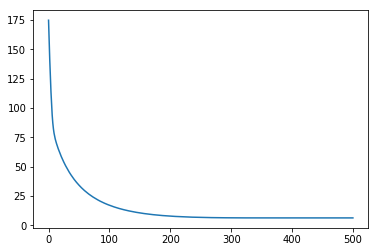

In [0]:
# plot loss history
pylab.plot(loss_history)

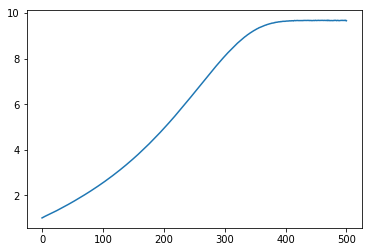

In [0]:
# plot std_1 history
pylab.plot(std_1_history)

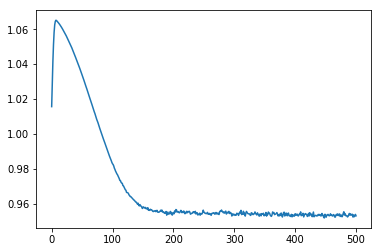

In [0]:
# plot std_2 history
pylab.plot(std_2_history)

## Prediction

In [0]:
with torch.no_grad():
    [predict_1, predict_2] = model(torch.from_numpy(X))
    predict_1 = predict_1.numpy()
    predict_2 = predict_2.numpy()

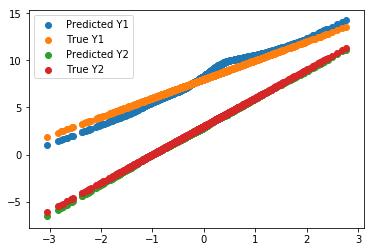

In [0]:
pylab.scatter(X[:, 0], predict_1[:, 0], label='Predicted Y1')
pylab.scatter(X[:, 0], 2*X[:, 0]+8, label='True Y1')
pylab.scatter(X[:, 0], predict_2[:, 0], label='Predicted Y2')
pylab.scatter(X[:, 0], 3*X[:, 0]+3, label='True Y2')
pylab.legend()
pylab.show()